In [1]:
import pandas as pd
import torch
from transformers import T5ForConditionalGeneration,T5Tokenizer
import sentencepiece
import os
import argparse
import random
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import evaluate as evaluate_hf

In [2]:
import sys
sys.argv = ['help.ipynb', '--mode', 'train']

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ParaphraseDataset(Dataset):
    def __init__(self, texts, paraphrases, tokenizer, max_len=128):
        self.texts = texts
        self.paraphrases = paraphrases
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_text = "paraphrase: " + self.texts[idx]
        target_text = self.paraphrases[idx]

        source = self.tokenizer.encode_plus(
            input_text, max_length=self.max_len, padding='max_length',
            truncation=True, return_tensors="pt"
        )
        target = self.tokenizer.encode_plus(
            target_text, max_length=self.max_len, padding='max_length',
            truncation=True, return_tensors="pt"
        )

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }

In [ ]:
def train_epoch(model, dataloader, optimizer, tokenizer):
    model.train()
    total_loss = 0
    loop = tqdm(dataloader, desc="Training", leave=False)

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        labels[labels == tokenizer.pad_token_id] = -100

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(dataloader)

In [6]:
def evaluate_model(model, dataloader, tokenizer):
    model.eval()
    predictions, references = [], []
    rouge = evaluate_hf.load("rouge")

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                     max_length=128, num_beams=4, early_stopping=True)

            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
    return result

In [7]:
def run_inference(model, tokenizer):
    model.eval()
    while True:
        text = input("\nEnter a sentence to paraphrase (or 'exit'): ")
        if text.lower() == 'exit':
            break

        input_text = "paraphrase: " + text
        inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)

        outputs = model.generate(inputs, max_length=128, num_beams=5, early_stopping=True)
        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"Paraphrased: {generated}")


In [8]:
def main(args):
    tokenizer = T5Tokenizer.from_pretrained(args.model_name)
    model = T5ForConditionalGeneration.from_pretrained(args.model_name).to(device)

    if args.mode == 'train':
        df = pd.read_csv(args.data_file)
        df = df.dropna()
        texts = df['Text'].tolist()
        targets = df['Paraphrase'].tolist()

        train_texts, val_texts, train_targets, val_targets = train_test_split(
            texts, targets, test_size=0.1, random_state=42
        )

        train_dataset = ParaphraseDataset(train_texts, train_targets, tokenizer, args.max_len)
        val_dataset = ParaphraseDataset(val_texts, val_targets, tokenizer, args.max_len)

        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size)

        optimizer = AdamW(model.parameters(), lr=args.learning_rate)

        for epoch in range(args.epochs):
            print(f"\nEpoch {epoch+1}/{args.epochs}")
            train_loss = train_epoch(model, train_loader, optimizer, tokenizer)
            print(f"Train Loss: {train_loss:.4f}")

            metrics = evaluate_model(model, val_loader, tokenizer)
            print("Validation ROUGE:", metrics)

            os.makedirs(args.save_dir, exist_ok=True)
            model.save_pretrained(args.save_dir)
            tokenizer.save_pretrained(args.save_dir)

    elif args.mode == 'evaluate':
        model = T5ForConditionalGeneration.from_pretrained(args.save_dir).to(device)
        tokenizer = T5Tokenizer.from_pretrained(args.save_dir)

        df = pd.read_csv(args.data_file)
        df = df.dropna()
        texts = df['Text'].tolist()
        targets = df['Paraphrase'].tolist()

        _, val_texts, _, val_targets = train_test_split(texts, targets, test_size=0.1, random_state=42)
        val_dataset = ParaphraseDataset(val_texts, val_targets, tokenizer, args.max_len)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size)

        metrics = evaluate_model(model, val_loader, tokenizer)
        print("Validation ROUGE:", metrics)

    elif args.mode == 'inference':
        model = T5ForConditionalGeneration.from_pretrained(args.save_dir).to(device)
        tokenizer = T5Tokenizer.from_pretrained(args.save_dir)
        run_inference(model, tokenizer)

In [9]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--mode', choices=['train', 'evaluate', 'inference'], required=True)
    parser.add_argument('--data_file', type=str, default='paraphrase_final.csv')
    parser.add_argument('--model_name', type=str, default='t5-small')
    parser.add_argument('--save_dir', type=str, default='t5_paraphrase')
    parser.add_argument('--max_len', type=int, default=128)
    parser.add_argument('--batch_size', type=int, default=8)
    parser.add_argument('--epochs', type=int, default=5)
    parser.add_argument('--learning_rate', type=float, default=5e-5)

    args = parser.parse_args()
    main(args)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Epoch 1/5


Training:   0%|                                                                              | 0/20738 [00:00<?, ?it/s]Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
                                                                                                                       

Train Loss: 1.6068


Evaluating: 100%|████████████████████████████████████████████████████████████████| 2305/2305 [1:13:07<00:00,  1.90s/it]


Validation ROUGE: {'rouge1': np.float64(0.6323819624988716), 'rouge2': np.float64(0.3934939481479874), 'rougeL': np.float64(0.5889824698577151), 'rougeLsum': np.float64(0.5889665514421092)}

Epoch 2/5


Train Loss: 1.4546


Evaluating: 100%|████████████████████████████████████████████████████████████████| 2305/2305 [1:13:28<00:00,  1.91s/it]


Validation ROUGE: {'rouge1': np.float64(0.6358506183284254), 'rouge2': np.float64(0.3987209290682566), 'rougeL': np.float64(0.592802910315406), 'rougeLsum': np.float64(0.592880733193722)}

Epoch 3/5


Train Loss: 1.3800


Evaluating: 100%|████████████████████████████████████████████████████████████████| 2305/2305 [1:12:56<00:00,  1.90s/it]


Validation ROUGE: {'rouge1': np.float64(0.6362647524415695), 'rouge2': np.float64(0.40041076461295433), 'rougeL': np.float64(0.5937145543871059), 'rougeLsum': np.float64(0.5936972199247759)}

Epoch 4/5


Train Loss: 1.3266


Evaluating: 100%|████████████████████████████████████████████████████████████████| 2305/2305 [1:13:36<00:00,  1.92s/it]


Validation ROUGE: {'rouge1': np.float64(0.636594723475627), 'rouge2': np.float64(0.4015574758997875), 'rougeL': np.float64(0.5936706328360577), 'rougeLsum': np.float64(0.5937235245967943)}

Epoch 5/5


Train Loss: 1.2825


Evaluating: 100%|████████████████████████████████████████████████████████████████| 2305/2305 [1:12:59<00:00,  1.90s/it]


Validation ROUGE: {'rouge1': np.float64(0.6384349145761963), 'rouge2': np.float64(0.4034935292603301), 'rougeL': np.float64(0.5958840573134407), 'rougeLsum': np.float64(0.5958473532156363)}


In [14]:
def evaluate_model(model, dataloader, tokenizer):
    model.eval()
    predictions, references = [], []

    rouge = evaluate_hf.load("rouge")
    bleu = evaluate_hf.load("bleu")

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                     max_length=128, num_beams=4, early_stopping=True)

            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    # Compute metrics
    rouge_result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
    bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])

    return {"rouge": rouge_result, "bleu": bleu_result}


In [ ]:
import evaluate as evaluate_hf
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
import torch

model = T5ForConditionalGeneration.from_pretrained('t5_paraphrase').to(device)
tokenizer = T5Tokenizer.from_pretrained('t5_paraphrase')

df = pd.read_csv('paraphrase_final.csv').dropna()
texts = df['Text'].tolist()
targets = df['Paraphrase'].tolist()

_, val_texts, _, val_targets = train_test_split(texts, targets, test_size=0.1, random_state=42)
val_dataset = ParaphraseDataset(val_texts, val_targets, tokenizer, max_len=128)
val_loader = DataLoader(val_dataset, batch_size=8)

rouge = evaluate_hf.load("rouge")
bleu = evaluate_hf.load("bleu")

model.eval()
predictions, references = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", dynamic_ncols=True):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            num_beams=4,
            early_stopping=True
        )

        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

rouge_result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])

print("\n=== Validation Results ===")
print("ROUGE:", rouge_result)
print("BLEU:", bleu_result)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 2305/2305 [1:14:56<00:00,  1.95s/it]



=== Validation Results ===
ROUGE: {'rouge1': np.float64(0.6384349145761963), 'rouge2': np.float64(0.4034935292603301), 'rougeL': np.float64(0.5958840573134407), 'rougeLsum': np.float64(0.5958473532156363)}
BLEU: {'bleu': 0.31268859671912574, 'precisions': [0.6581732546517518, 0.40405726615406845, 0.27388157569838073, 0.18983694424604264], 'brevity_penalty': 0.9118646240473623, 'length_ratio': 0.9155297981422906, 'translation_length': 219111, 'reference_length': 239327}


In [16]:
rouge_df = pd.DataFrame.from_dict(rouge_result, orient='index', columns=['Score'])
bleu_df = pd.DataFrame.from_dict({
    'BLEU Score': [bleu_result['bleu']],
    'Precision-1': [bleu_result['precisions'][0]],
    'Precision-2': [bleu_result['precisions'][1]],
    'Precision-3': [bleu_result['precisions'][2]],
    'Precision-4': [bleu_result['precisions'][3]],
    'Brevity Penalty': [bleu_result['brevity_penalty']],
    'Length Ratio': [bleu_result['length_ratio']],
    'Translation Length': [bleu_result['translation_length']],
    'Reference Length': [bleu_result['reference_length']]
})

print("\n=== ROUGE Scores ===")
print(rouge_df.round(4))

print("\n=== BLEU Scores ===")
print(bleu_df.round(4))



=== ROUGE Scores ===
            Score
rouge1     0.6384
rouge2     0.4035
rougeL     0.5959
rougeLsum  0.5958

=== BLEU Scores ===
   BLEU Score  Precision-1  Precision-2  Precision-3  Precision-4  \
0      0.3127       0.6582       0.4041       0.2739       0.1898   

   Brevity Penalty  Length Ratio  Translation Length  Reference Length  
0           0.9119        0.9155              219111            239327  


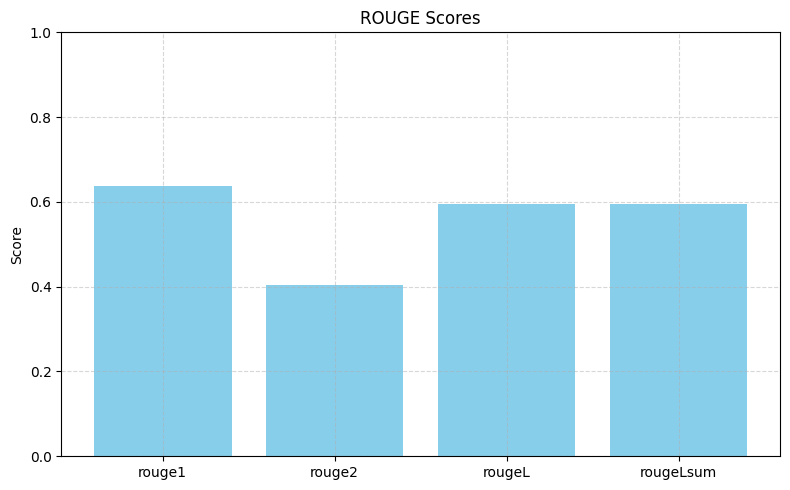

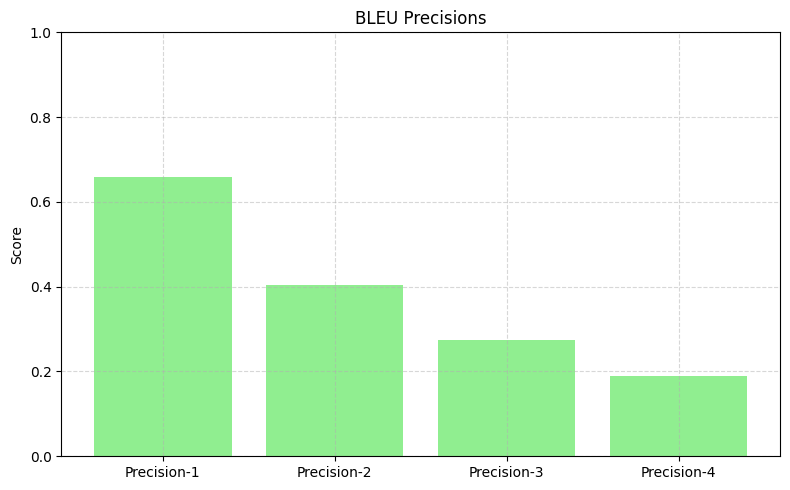

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(rouge_result.keys(), [float(v) for v in rouge_result.values()], color='skyblue')
plt.title('ROUGE Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("rouge_scores.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar([f'Precision-{i+1}' for i in range(4)], bleu_result['precisions'], color='lightgreen')
plt.title('BLEU Precisions')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("bleu_precisions.png")
plt.show()

In [22]:
from rouge_score import rouge_scorer

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4476\1366781151.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rouge_df, x='Metric', y='Score', palette='Blues_d', ax=axes[0,0])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4476\1366781151.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bleu_df_prec, x='Precision', y='Score', palette='Greens_d', ax=axes[0,1])


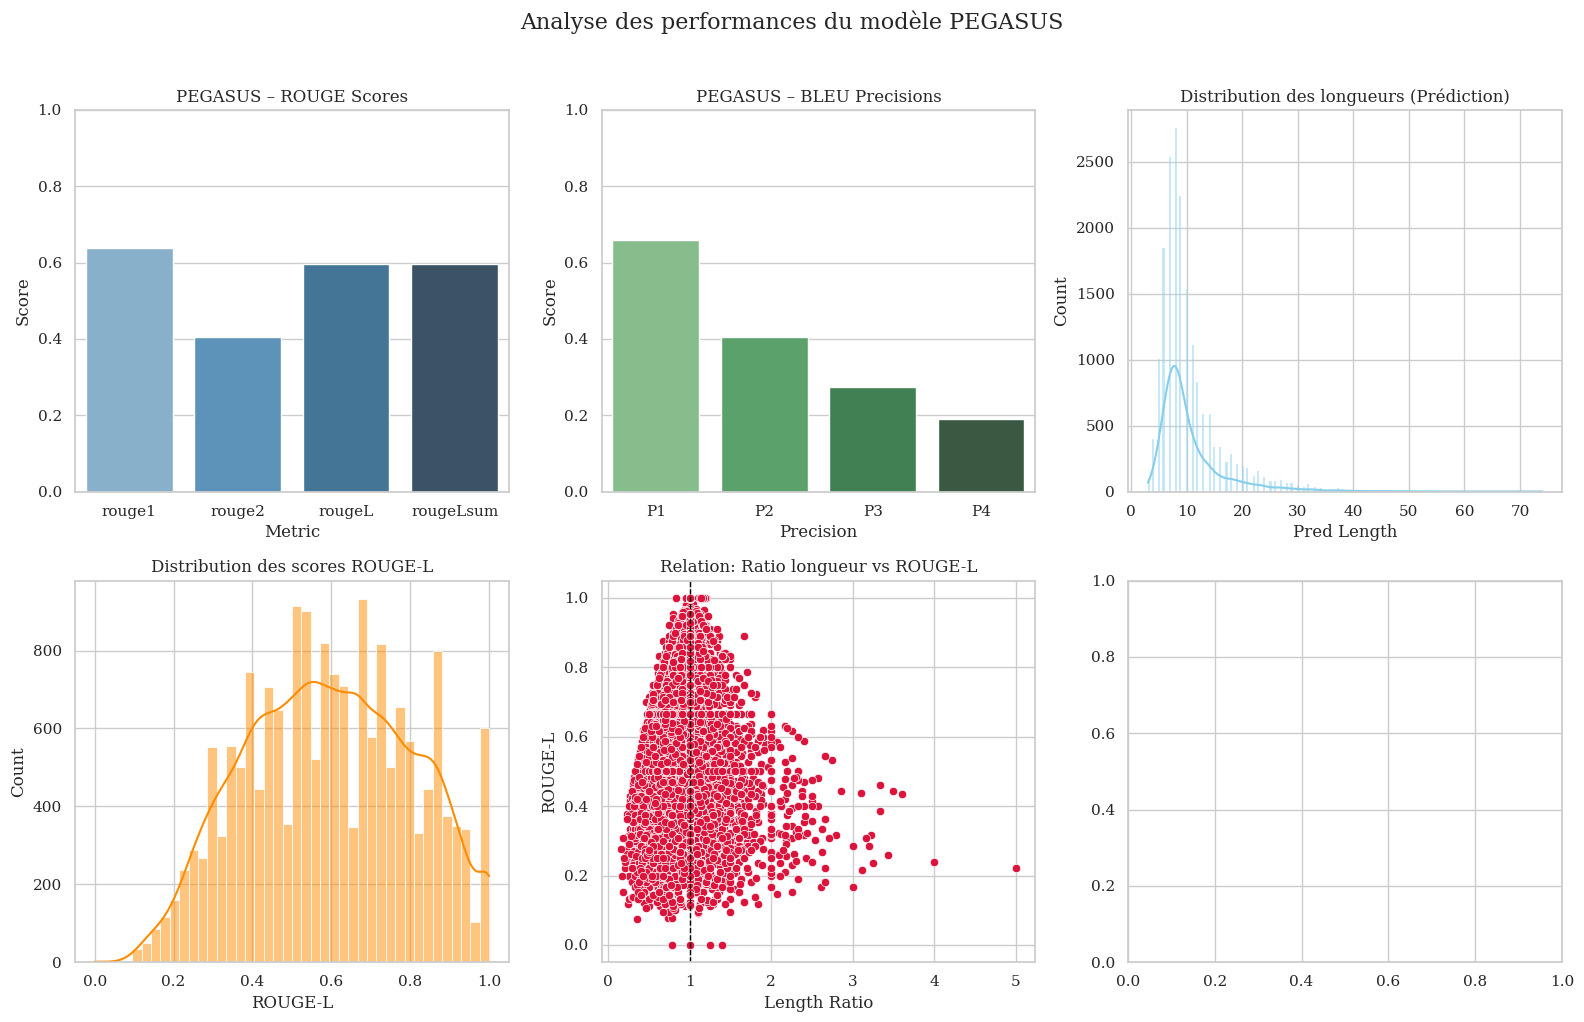

In [ ]:

results_df = pd.DataFrame({
    'Prediction':  predictions,
    'Reference':   references,
    'Pred Length': [len(p.split()) for p in predictions],
    'Ref Length':  [len(r.split()) for r in references]
})

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
results_df['ROUGE-L'] = [
    scorer.score(ref, pred)['rougeL'].fmeasure
    for ref, pred in zip(results_df['Reference'], results_df['Prediction'])
]
results_df['Length Ratio'] = results_df['Pred Length'] / results_df['Ref Length']
results_df['BLEU'] = bleu_result['bleu'] 

rouge_df = pd.DataFrame.from_dict(rouge_result, orient='index', columns=['Score']).reset_index().rename(columns={'index':'Metric'})
bleu_df_prec = pd.DataFrame({
    'Precision': [f'P{i+1}' for i in range(4)],
    'Score': bleu_result['precisions']
})


sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (16, 10), 'font.family': 'serif'})

fig, axes = plt.subplots(2, 3)

sns.barplot(data=rouge_df, x='Metric', y='Score', palette='Blues_d', ax=axes[0,0])
axes[0,0].set_ylim(0,1)
axes[0,0].set_title('PEGASUS – ROUGE Scores')

sns.barplot(data=bleu_df_prec, x='Precision', y='Score', palette='Greens_d', ax=axes[0,1])
axes[0,1].set_ylim(0,1)
axes[0,1].set_title('PEGASUS – BLEU Precisions')

sns.histplot(results_df['Pred Length'], kde=True, color='skyblue', ax=axes[0,2])
axes[0,2].set_title('Distribution des longueurs (Prédiction)')

sns.histplot(results_df['ROUGE-L'], kde=True, color='darkorange', ax=axes[1,0])
axes[1,0].set_title('Distribution des scores ROUGE-L')

sns.scatterplot(data=results_df, x='Length Ratio', y='ROUGE-L', color='crimson', ax=axes[1,1])
axes[1,1].axvline(1.0, color='black', linestyle='--', linewidth=1)
axes[1,1].set_title('Relation: Ratio longueur vs ROUGE-L')

plt.tight_layout(rect=[0,0,1,0.96])
plt.suptitle("Analyse des performances du modèle PEGASUS", fontsize=16, y=1.02)
plt.savefig('t5_full_dashboard.png')
plt.show()

In [27]:
import seaborn as sns